In [ ]:
# default_exp learner

In [ ]:
#export
# Contains code used/modified by fastai_minima author from fastai
# Copyright 2019 the fast.ai team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language

In [ ]:
#hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
import pickle
from contextlib import contextmanager

from fastcore.basics import GetAttr, add_props, store_attr, detuplify, patch, Self
from fastcore.foundation import L
from fastcore.meta import delegates
from fastcore.xtras import Path, join_path_file, ContextManagers

from fastai_minima.callback.core import (
    event, Callback, GatherPredsCallback,
    CancelStepException,CancelFitException,
    CancelEpochException,CancelTrainException,
    CancelValidException,CancelBatchException,
    TrainEvalCallback, GatherPredsCallback, 
)
from fastai_minima.optimizer import Adam
from fastai_minima.utils import (
    defaults, trainable_params, noop, norm_bias_params, 
    find_device, tensor, rank_distrib, get_model, distrib_barrier, NoneType,
    to_detach, find_bs
)

import torch, time
import numpy as np
import matplotlib.pyplot as plt

from builtins import NotImplementedError

# Learner, Metrics, and Basic Callbacks

> Basic class for handling the training loop

For the actual fastai documentation, you should go to the [Learner](docs.fast.ai/Learner) documentation. These are minimal docs simply to bring in the source code and related tests to ensure that minimal functionality is met

You probably want to jump directly to the definition of `Learner`.

In [ ]:
#export
class DataLoaders(GetAttr):
    "Basic wrapper around several `DataLoader`s."
    _default='train'
    def __init__(self, *loaders, path='.'):
        self.loaders,self.path = list(loaders),Path(path)

    def __getitem__(self, i): return self.loaders[i]
    def new_empty(self):
        loaders = [dl.new(dl.dataset.new_empty()) for dl in self.loaders]
        return type(self)(*loaders, path=self.path, device=self.device)

    def _set(i, self, v): self.loaders[i] = v
    train   ,valid    = add_props(lambda i,x: x[i], _set)
    train_ds,valid_ds = add_props(lambda i,x: x[i].dataset)
    
    def one_batch(self, ds_idx=0):
        "Grab one batch of data from the `DataLoader` at `ds_idx` in `self.loaders`"
        return next(iter(self.loaders[ds_idx]))

## Utils function

In [ ]:
#hide
#For tests
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

In [ ]:
#hide
def synth_dbunch(a=2, b=3, bs=16, n_train=10, n_valid=2):
    "A simple dataset where `x` is random and `y = a*x + b` plus some noise."
    def get_data(n):
        x = torch.randn(int(bs*n))
        return TensorDataset(x, a*x + b + 0.1*torch.randn(int(bs*n)))
    train_ds = get_data(n_train)
    valid_ds = get_data(n_valid)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=0)
    valid_dl = DataLoader(valid_ds, batch_size=bs, num_workers=0)
    return DataLoaders(train_dl, valid_dl)

class RegModel(nn.Module):
    "A r"
    def __init__(self): 
        super().__init__()
        self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
    def forward(self, x): return x*self.a + self.b

In [ ]:
# export
defaults.lr = 1e-3

In [ ]:
# export
def replacing_yield(o, attr, val):
    "Context manager to temporarily replace an attribute"
    old = getattr(o,attr)
    try:     yield setattr(o,attr,val)
    finally: setattr(o,attr,old)

In [ ]:
class _A:
    def __init__(self, a): self.a = a
    @contextmanager
    def a_changed(self, v): return replacing_yield(self, 'a', v)

a = _A(42)
with a.a_changed(32):
    test_eq(a.a, 32)
test_eq(a.a, 42)

In [ ]:
#export
def mk_metric(m):
    "Convert `m` to an `AvgMetric`, unless it's already a `Metric`"
    if isinstance(m,type): m = m()
    return m if isinstance(m, Metric) else AvgMetric(m)

See the class `Metric` below for more information.

In [ ]:
#export
def save_model(file, model, opt, with_opt=True, pickle_protocol=2):
    "Save `model` to `file` along with `opt` (if available, and if `with_opt`)"
    if rank_distrib(): return # don't save if child proc
    if opt is None: with_opt=False
    state = get_model(model).state_dict()
    if with_opt: state = {'model': state, 'opt':opt.state_dict()}
    torch.save(state, file, pickle_protocol=pickle_protocol)

`file` can be a `Path` object, a string or an opened file object. `pickle_protocol` is passed along to `torch.save`

In [ ]:
# export
def load_model(file, model, opt, with_opt=True, device=None, strict=True):
    "Load `model` from `file` along with `opt` (if available, and if `with_opt`)"
    distrib_barrier()
    if isinstance(device, int): device = torch.device('cuda', device)
    elif device is None: device = 'cpu'
    state = torch.load(file, map_location=device)
    hasopt = set(state)=={'model', 'opt'}
    model_state = state['model'] if hasopt else state
    get_model(model).load_state_dict(model_state, strict=strict)
    if hasopt and with_opt:
        try: opt.load_state_dict(state['opt'])
        except:
            if with_opt: warn("Could not load the optimizer state.")
    elif with_opt: warn("Saved filed doesn't contain an optimizer state.")

`file` can be a `Path` object, a string or an opened file object. If a `device` is passed, the model is loaded on it, otherwise it's loaded on the CPU. 

If `strict` is `True`, the file must exactly contain weights for every parameter key in `model`, if `strict` is `False`, only the keys that are in the saved model are loaded in `model`.

In [ ]:
# export
def _try_concat(o):
    try:    return torch.cat(o)
    except: return sum([L(o_[i,:] for i in range_of(o_)) for o_ in o], L())

In [ ]:
#export
_before_epoch = [event.before_fit, event.before_epoch]
_after_epoch  = [event.after_epoch, event.after_fit]

In [ ]:
#export
class _ConstantFunc():
    "Returns a function that returns `o`"
    def __init__(self, o): self.o = o
    def __call__(self, *args, **kwargs): return self.o

## Learner -

In [ ]:
#export
_loop = ['Start Fit', 'before_fit', 'Start Epoch Loop', 'before_epoch', 'Start Train', 'before_train',
         'Start Batch Loop', 'before_batch', 'after_pred', 'after_loss', 'before_backward', 'before_step',
         'after_step', 'after_cancel_batch', 'after_batch','End Batch Loop','End Train',
         'after_cancel_train', 'after_train', 'Start Valid', 'before_validate','Start Batch Loop',
         '**CBs same as train batch**', 'End Batch Loop', 'End Valid', 'after_cancel_validate',
         'after_validate', 'End Epoch Loop', 'after_cancel_epoch', 'after_epoch', 'End Fit',
         'after_cancel_fit', 'after_fit']

In [ ]:
# export
class Learner(GetAttr):
    _default='model'
    def __init__(self, dls, model, loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=trainable_params, cbs=None,
                 metrics=None, path=None, model_dir='models', wd=None, wd_bn_bias=False, train_bn=True,
                 moms=(0.95,0.85,0.95)):
        "Group together a `model`, some `dls` and a `loss_func` to handle training"
        path = Path(path) if path is not None else getattr(dls, 'path', Path('.'))
        if loss_func is None:
            loss_func = getattr(dls.train_ds, 'loss_func', None)
            assert loss_func is not None, "Could not infer loss function from the data, please pass a loss function."
        self.dls,self.model = dls,model
        store_attr(but='dls,model,cbs')
        self.training,self.create_mbar,self.logger,self.opt,self.cbs = False,True,print,None,L()
        self.add_cbs(L(defaults.callbacks)+L(cbs))
        self("after_create")

    @property
    def metrics(self): return self._metrics
    @metrics.setter
    def metrics(self,v): self._metrics = L(v).map(mk_metric)

    def _grab_cbs(self, cb_cls): return L(cb for cb in self.cbs if isinstance(cb, cb_cls))

    def add_cbs(self, cbs):
        "Add `cbs` to the list of `Callback` and register `self` as their learner"
        L(cbs).map(self.add_cb)
        return self

    def remove_cbs(self, cbs):
        "Remove `cbs` from the list of `Callback` and deregister `self` as their learner"
        L(cbs).map(self.remove_cb)
        return self

    def add_cb(self, cb):
        "Add `cb` to the list of `Callback` and register `self` as their learner"
        if isinstance(cb, type): cb = cb()
        cb.learn = self
        setattr(self, cb.name, cb)
        self.cbs.append(cb)
        return self

    def remove_cb(self, cb):
        "Add `cb` from the list of `Callback` and deregister `self` as their learner"
        if isinstance(cb, type): self.remove_cbs(self._grab_cbs(cb))
        else:
            cb.learn = None
            if hasattr(self, cb.name): delattr(self, cb.name)
            if cb in self.cbs: self.cbs.remove(cb)
        return self

    @contextmanager
    def added_cbs(self, cbs):
        "Context manage that temporarily adds `cbs`"
        self.add_cbs(cbs)
        try: yield
        finally: self.remove_cbs(cbs)

    @contextmanager
    def removed_cbs(self, cbs):
        "Context manage that temporarily removes `cbs`"
        self.remove_cbs(cbs)
        try: yield self
        finally: self.add_cbs(cbs)

    def ordered_cbs(self, event): 
        "List of `Callback`s, in order, for an `event` in the training loop"
        return [cb for cb in self.cbs.sorted('order') if hasattr(cb, event)]
    def __call__(self, event_name): 
        "Call `event_name` for all `Callback`s in `self.cbs`"
        L(event_name).map(self._call_one)

    def _call_one(self, event_name):
        if not hasattr(event, event_name): raise Exception(f'missing {event_name}')
        for cb in self.cbs.sorted('order'): cb(event_name)

    def _bn_bias_state(self, with_bias): return norm_bias_params(self.model, with_bias).map(self.opt.state)
    def create_opt(self):
        "Create an optimizer with default hyper-parameters"
        self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
        if not self.wd_bn_bias:
            for p in self._bn_bias_state(True ): p['do_wd'] = False
        if self.train_bn:
            for p in self._bn_bias_state(False): p['force_train'] = True

    def _split(self, b):
        i = getattr(self.dls, 'n_inp', 1 if len(b)==1 else len(b)-1)
        self.xb,self.yb = b[:i],b[i:]

    def _with_events(self, f, event_type, ex, final=noop):
        try: self(f'before_{event_type}');  f()
        except ex: self(f'after_cancel_{event_type}')
        self(f'after_{event_type}');  final()

    def all_batches(self):
        "Train or evaluate `self.model` on all the batches of `self.dl`"
        self.n_iter = len(self.dl)
        for o in enumerate(self.dl): self.one_batch(*o)

    def _do_one_batch(self):
        self.pred = self.model(*self.xb)
        self('after_pred')
        if len(self.yb):
            self.loss_grad = self.loss_func(self.pred, *self.yb)
            self.loss = self.loss_grad.clone()
        self('after_loss')
        if not self.training or not len(self.yb): return
        self('before_backward')
        self.loss_grad.backward()
        self._with_events(self.opt.step, 'step', CancelStepException)
        self.opt.zero_grad()

    def one_batch(self, i, b):
        "Train or evaluate `self.model` on batch `(xb,yb)`"
        self.iter = i
        self._split(b)
        self._with_events(self._do_one_batch, 'batch', CancelBatchException)

    def _do_epoch_train(self):
        self.dl = self.dls.train
        self._with_events(self.all_batches, 'train', CancelTrainException)

    def _do_epoch_validate(self, ds_idx=1, dl=None):
        if dl is None: dl = self.dls[ds_idx]
        self.dl = dl
        with torch.no_grad(): self._with_events(self.all_batches, 'validate', CancelValidException)

    def _do_epoch(self):
        self._do_epoch_train()
        self._do_epoch_validate()

    def _do_fit(self):
        for epoch in range(self.n_epoch):
            self.epoch=epoch
            self._with_events(self._do_epoch, 'epoch', CancelEpochException)

    def fit(self, n_epoch, lr=None, wd=None, cbs=None, reset_opt=False):
        "Fit `self.model` for `n_epoch` using `cbs`. Optionally `reset_opt`."
        with self.added_cbs(cbs):
            if reset_opt or not self.opt: self.create_opt()
            if wd is None: wd = self.wd
            if wd is not None: self.opt.set_hypers(wd=wd)
            self.opt.set_hypers(lr=self.lr if lr is None else lr)
            self.n_epoch = n_epoch
            self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)

    def _end_cleanup(self): self.dl,self.xb,self.yb,self.pred,self.loss = None,(None,),(None,),None,None
    def __enter__(self): self(_before_epoch); return self
    def __exit__(self, exc_type, exc_value, tb): self(_after_epoch)

    def validation_context(self, cbs=None, inner=False):
        "A `ContextManagers` suitable for validation, with optional `cbs`"
        cms = [self.no_logging(),self.no_mbar()]
        if cbs: cms.append(self.added_cbs(cbs))
        if not inner: cms.append(self)
        return ContextManagers(cms)

    def validate(self, ds_idx=1, dl=None, cbs=None):
        "Validate on `dl` with potential new `cbs`."
        if dl is None: dl = self.dls[ds_idx]
        with self.validation_context(cbs=cbs): self._do_epoch_validate(ds_idx, dl)
        return getattr(self, 'final_record', None)

    @delegates(GatherPredsCallback.__init__)
    def get_preds(self, ds_idx=1, dl=None, with_input=False, with_decoded=False, with_loss=False, act=None,
                  inner=False, reorder=False, cbs=None, **kwargs):
        "Get the predictions and targets on the `ds_idx`-th dbunchset or `dl`, optionally `with_input` and `with_loss`"
        if dl is None: dl = self.dls[ds_idx]
        else:
            try: len(dl)
            except TypeError as e:
                raise TypeError("`dl` is something other than a single `DataLoader` object")
        if reorder and hasattr(dl, 'get_idxs'):
            raise NotImplementedError("You're trying to use non-basic fastai functionality. You should use the entire fastai API to get this feature")
        cb = GatherPredsCallback(with_input=with_input, with_loss=with_loss, **kwargs)
        ctx_mgrs = self.validation_context(cbs=L(cbs)+[cb], inner=inner)
        if with_loss: ctx_mgrs.append(self.loss_not_reduced())
        with ContextManagers(ctx_mgrs):
            self._do_epoch_validate(dl=dl)
            if act is None: act = getattr(self.loss_func, 'activation', noop)
            res = cb.all_tensors()
            pred_i = 1 if with_input else 0
            if res[pred_i] is not None:
                res[pred_i] = act(res[pred_i])
                if with_decoded: res.insert(pred_i+2, getattr(self.loss_func, 'decodes', noop)(res[pred_i]))
            if reorder and hasattr(dl, 'get_idxs'): res = nested_reorder(res, tensor(idxs).argsort())
            return tuple(res)
        self._end_cleanup()

    def predict(self, item, rm_type_tfms=None, with_input=False):
        "Prediction on `item`, fully decoded, loss function decoded and probabilities"
        raise NotImplementedError("You're trying to use non-basic fastai functionality. You should use the entire fastai API to get this feature")

    def show_results(self, ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
        "Show some predictions on `ds_idx`-th dataset or `dl`"
        raise NotImplementedError("You're trying to use non-basic fastai functionality. You should use the entire fastai API to get this feature")

    def show_training_loop(self):
        "Show each step in the training loop"
        indent = 0
        for s in _loop:
            if s.startswith('Start'): print(f'{" "*indent}{s}'); indent += 2
            elif s.startswith('End'): indent -= 2; print(f'{" "*indent}{s}')
            else: print(f'{" "*indent} - {s:15}:', self.ordered_cbs(s))

    @contextmanager
    def no_logging(self): 
        "Context manager to temporarily remove `logger`"
        return replacing_yield(self, 'logger', noop)
    @contextmanager
    def no_mbar(self):    
        "Context manager to temporarily prevent the master progress bar from being created"
        return replacing_yield(self, 'create_mbar', False)

    @contextmanager
    def loss_not_reduced(self):
        "A context manager to evaluate `loss_func` with reduction set to none."
        if hasattr(self.loss_func, 'reduction'): return replacing_yield(self.loss_func, 'reduction', 'none')
        else: return replacing_yield(self, 'loss_func', partial(self.loss_func, reduction='none'))

    def to_detach(self,b,cpu=True,gather=True):
        "Calls `to_detach` if `self.dl` provides a `.to_detach` function otherwise calls global `to_detach`"
        return self.dl.to_detach(b,cpu,gather) if hasattr(getattr(self,'dl',None),'to_detach') else to_detach(b,cpu,gather)

Learner.x,Learner.y = add_props(lambda i,x: detuplify((x.xb,x.yb)[i]))

In [ ]:
show_doc(Learner)

<h2 id="Learner" class="doc_header"><code>class</code> <code>Learner</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>Learner</code>(**`dls`**, **`model`**, **`loss_func`**=*`None`*, **`opt_func`**=*`Adam`*, **`lr`**=*`0.001`*, **`splitter`**=*`trainable_params`*, **`cbs`**=*`None`*, **`metrics`**=*`None`*, **`path`**=*`None`*, **`model_dir`**=*`'models'`*, **`wd`**=*`None`*, **`wd_bn_bias`**=*`False`*, **`train_bn`**=*`True`*, **`moms`**=*`(0.95, 0.85, 0.95)`*) :: `GetAttr`

Inherit from this to have all attr accesses in `self._xtra` passed down to `self.default`

`opt_func` will be used to create an optimizer when `Learner.fit` is called, with `lr` as a default learning rate. `splitter` is a function that takes `self.model` and returns a list of parameter groups (or just one parameter group if there are no different parameter groups). The default is `trainable_params`, which returns all trainable parameters of the model.

`cbs` is one or a list of `Callback`s  to pass to the `Learner`. `Callback`s are used for every tweak of the training loop. Each `Callback` is registered as an attribute of `Learner` (with camel case). At creation, all the callbacks in `defaults.callbacks` (`TrainEvalCallback`, `Recorder` and `ProgressCallback`) are associated to the `Learner`.

`metrics` is an optional list of metrics, that can be either functions or `Metric`s (see below). 

`path` and `model_dir` are used to save and/or load models. Often `path` will be inferred from `dls`, but you can override it or pass a `Path`  object to `model_dir`. Make sure you can write in `path/model_dir`!

`wd` is the default weight decay used when training the model; `moms`, the default momentums used in `Learner.fit_one_cycle`. `wd_bn_bias` controls if weight decay is applied to `BatchNorm` layers and bias. 

Lastly, `train_bn` controls if `BatchNorm` layers are trained even when they are supposed to be frozen according to the `splitter`. Our empirical experiments have shown that it's the best behavior for those layers in transfer learning.

### PyTorch interop

You can use regular PyTorch functionality for most of the arguments of the `Learner`, although the experience will be smoother with pure fastai objects and you will be able to use the full functionality of the library. The expectation is that the training loop will work smoothly even if you did not use fastai end to end. What you might lose are interpretation objects or showing functionality. The list below explains how to use plain PyTorch objects for all the arguments and what you might lose.

The most important is `opt_func`. If you are not using a fastai optimizer, you will need to write a function that wraps your PyTorch optimizer in an `OptimWrapper`. See the [optimizer module](http://docs.fast.ai/optimizer) for more details. This is to ensure the library's schedulers/freeze API work with your code.

- `dls` is a `DataLoaders` object, that you can create from standard PyTorch dataloaders. By doing so, you will lose all showing functionality like `show_batch`/`show_results`. You can check the [data block API](http://docs.fast.ai/tutorial.datablock) or the [mid-level data API tutorial](http://docs.fast.ai/tutorial.pets) to learn how to use fastai to gather your data!
- `model` is a standard PyTorch model. You can use anyone you like, just make sure it accepts the number of inputs you have in your `DataLoaders` and returns as many outputs as you have targets.
- `loss_func` can be any loss function you like. It needs to be one of fastai's if you want to use `Learn.predict` or `Learn.get_preds`, or you will have to implement special methods (see more details after the `BaseLoss` documentation).

### Training loop

Now let's look at the main thing the `Learner` class implements: the training loop.

In [ ]:
#export
if not hasattr(defaults, 'callbacks'): defaults.callbacks = [TrainEvalCallback]

In [ ]:
show_doc(Learner.fit)

<h4 id="Learner.fit" class="doc_header"><code>Learner.fit</code><a href="__main__.py#L137" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.fit</code>(**`n_epoch`**, **`lr`**=*`None`*, **`wd`**=*`None`*, **`cbs`**=*`None`*, **`reset_opt`**=*`False`*)

Fit `self.model` for `n_epoch` using `cbs`. Optionally `reset_opt`.

Uses `lr` and `wd` if they are provided, otherwise use the defaults values given by the `lr` and `wd` attributes of `Learner`.

All the examples use `synth_learner` which is a simple `Learner` training a linear regression model.

In [ ]:
#hide
def synth_learner(n_train=10, n_valid=2, lr=defaults.lr, **kwargs):
    data = synth_dbunch(n_train=n_train,n_valid=n_valid)
    return Learner(data, RegModel(), loss_func=nn.MSELoss(), lr=lr, **kwargs)

In [ ]:
#Training a few epochs should make the model better
learn = synth_learner(lr=0.1)
learn(_before_epoch)
learn.model = learn.model.cpu()
xb,yb = learn.dls.one_batch()
init_loss = learn.loss_func(learn.model(xb), yb)
learn.fit(10)
xb,yb = learn.dls.one_batch()
final_loss = learn.loss_func(learn.model(xb), yb)
assert final_loss < init_loss, (final_loss,init_loss)

/mnt/d/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


In [ ]:
#hide
class TestTrainEvalCallback(Callback):
    run_after,run_valid = TrainEvalCallback,False
    def before_fit(self): 
        test_eq([self.pct_train,self.train_iter], [0., 0])
        self.old_pct_train,self.old_train_iter = self.pct_train,self.train_iter
    
    def before_batch(self): test_eq(next(self.parameters()).device, find_device(self.xb))
    
    def after_batch(self):
        assert self.training
        test_eq(self.pct_train , self.old_pct_train+1/(self.n_iter*self.n_epoch))
        test_eq(self.train_iter, self.old_train_iter+1)
        self.old_pct_train,self.old_train_iter = self.pct_train,self.train_iter
    
    def before_train(self):
        assert self.training and self.model.training
        test_eq(self.pct_train, self.epoch/self.n_epoch)
        self.old_pct_train = self.pct_train
    
    def before_validate(self):
        assert not self.training and not self.model.training
        
learn = synth_learner(cbs=TestTrainEvalCallback)
learn.fit(1)
#Check order is properly taken into account
learn.cbs = L(reversed(learn.cbs))

In [ ]:
from fastai.optimizer import SGD
from functools import partial

In [ ]:
#hide
#Check wd is not applied on bn/bias when option wd_bn_bias=False
class _TstModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
        self.tst = nn.Sequential(nn.Linear(4,5), nn.BatchNorm1d(3))
        self.tst[0].bias.data,self.tst[1].bias.data = torch.randn(5),torch.randn(3) 
    def forward(self, x): return x * self.a + self.b
    
class _PutGrad(Callback):
    def before_step(self):
        for p in self.learn.tst.parameters():
            p.grad = torch.ones_like(p.data)
    
learn = synth_learner(n_train=5, opt_func = partial(SGD, wd=1, decouple_wd=True), cbs=_PutGrad)
learn.model = _TstModel()
init = [p.clone() for p in learn.tst.parameters()]
learn.fit(1, lr=1e-2)
end = list(learn.tst.parameters())
assert not torch.allclose(end[0]-init[0], -0.05 * torch.ones_like(end[0]))
for i in [1,2,3]: test_close(end[i]-init[i], -0.05 * torch.ones_like(end[i]))

In [ ]:
show_doc(Learner.one_batch)

<h4 id="Learner.one_batch" class="doc_header"><code>Learner.one_batch</code><a href="__main__.py#L113" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.one_batch</code>(**`i`**, **`b`**)

Train or evaluate `self.model` on batch `(xb,yb)`

This is an internal method called by `Learner.fit`. If passed, `i` is the index of this iteration in the epoch. In training mode, this does a full training step on the batch (compute predictions, loss, gradients, update the model parameters and zero the gradients). In validation mode, it stops at the loss computation. Training or validation is controlled internally by the `TrainEvalCallback` through the `training` attribute.

Nothing is returned, but the attributes `x`, `y`, `pred`, `loss` of the `Learner` are set with the proper values:

In [ ]:
b = learn.dls.one_batch()
learn.one_batch(0, b)
test_eq(learn.x, b[0])
test_eq(learn.y, b[1])
out = learn.model(learn.x)
test_eq(learn.pred, out)
test_eq(learn.loss, learn.loss_func(out, b[1]))

In [ ]:
#hide
class VerboseCallback(Callback):
    "Callback that prints the name of each event called"
    def __call__(self, event_name):
        print(event_name)
        super().__call__(event_name)

In [ ]:
#hide
class TestOneBatch(VerboseCallback):
    def __init__(self, xb, yb, i):
        self.save_xb,self.save_yb,self.i = xb,yb,i
        self.old_pred,self.old_loss = None,tensor(0.)
        
    def before_batch(self):
        self.old_a,self.old_b = self.a.data.clone(),self.b.data.clone()
        test_eq(self.iter,    self.i)
        test_eq(self.save_xb, *self.xb)
        test_eq(self.save_yb, *self.yb)
        if hasattr(self.learn, 'pred'): test_eq(self.pred, self.old_pred)
    
    def after_pred(self):
        self.old_pred = self.pred
        test_eq(self.pred, self.a.data * self.x + self.b.data)
        test_eq(self.loss, self.old_loss)
    
    def after_loss(self):
        self.old_loss = self.loss
        test_eq(self.loss, self.loss_func(self.old_pred, self.save_yb))
        for p in self.parameters(): 
            if not hasattr(p, 'grad') or p.grad is not None: test_eq(p.grad, tensor([0.]))
    
    def before_step(self):
        self.grad_a = (2 * self.x * (self.pred.data - self.y)).mean()
        self.grad_b = 2 * (self.pred.data - self.y).mean()
        test_close(self.a.grad.data, self.grad_a)
        test_close(self.b.grad.data, self.grad_b)
        test_eq(self.a.data, self.old_a)
        test_eq(self.b.data, self.old_b)
        
    def after_step(self):
        test_close(self.a.data, self.old_a - self.lr * self.grad_a)
        test_close(self.b.data, self.old_b - self.lr * self.grad_b)
        self.old_a,self.old_b = self.a.data.clone(),self.b.data.clone()
        test_close(self.a.grad.data, self.grad_a)
        test_close(self.b.grad.data, self.grad_b)
    
    def after_batch(self):
        for p in self.parameters(): test_eq(p.grad, tensor([0.]))

In [ ]:
#hide
learn = synth_learner()
b = learn.dls.one_batch()
learn = synth_learner(cbs=TestOneBatch(*b, 42), lr=1e-2)
#Remove train/eval
learn.cbs = learn.cbs[1:]
#Setup
learn.loss,learn.training = tensor(0.),True
learn.opt = SGD(learn.parameters(), lr=learn.lr)
learn.model.train()
batch_events = ['before_batch', 'after_pred', 'after_loss', 'before_backward', 'before_step', 'after_step', 'after_batch']
test_stdout(lambda: learn.one_batch(42, b), '\n'.join(batch_events))
test_stdout(lambda: learn.one_batch(42, b), '\n'.join(batch_events)) #Check it works for a second batch

after_create


In [ ]:
show_doc(Learner.all_batches)

<h4 id="Learner.all_batches" class="doc_header"><code>Learner.all_batches</code><a href="__main__.py#L95" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.all_batches</code>()

Train or evaluate `self.model` on all the batches of `self.dl`

In [ ]:
#hide
from contextlib import redirect_stdout
import io
learn = synth_learner(n_train=5, cbs=VerboseCallback())
learn.opt = SGD(learn.parameters(), lr=learn.lr)
with redirect_stdout(io.StringIO()): 
    learn(_before_epoch)
    learn.epoch,learn.dl = 0,learn.dls.train
    learn('before_train')
test_stdout(learn.all_batches, '\n'.join(batch_events * 5))
test_eq(learn.train_iter, 5)

valid_events = ['before_batch', 'after_pred', 'after_loss', 'after_batch']
with redirect_stdout(io.StringIO()): 
    learn.dl = learn.dls.valid
    learn('before_validate')
test_stdout(learn.all_batches, '\n'.join(valid_events * 2))
test_eq(learn.train_iter, 5)

after_create


In [ ]:
#hide
learn = synth_learner(n_train=5, cbs=VerboseCallback())
test_stdout(lambda: learn(_before_epoch), 'before_fit\nbefore_epoch')
test_eq(learn.loss, tensor(0.))

after_create


In [ ]:
#hide
learn.opt = SGD(learn.parameters(), lr=learn.lr)
learn.epoch = 0
test_stdout(lambda: learn._do_epoch_train(), '\n'.join(['before_train'] + batch_events * 5 + ['after_train']))

In [ ]:
#hide
test_stdout(learn._do_epoch_validate, '\n'.join(['before_validate'] + valid_events * 2+ ['after_validate']))

In [ ]:
show_doc(Learner.create_opt)

<h4 id="Learner.create_opt" class="doc_header"><code>Learner.create_opt</code><a href="__main__.py#L78" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.create_opt</code>()

Create an optimizer with default hyper-parameters

This method is called internally to create the optimizer, the hyper-parameters are then adjusted by what you pass to `Learner.fit` or your particular schedulers (see `callback.schedule`).

In [ ]:
learn = synth_learner(n_train=5, cbs=VerboseCallback())
assert learn.opt is None
learn.create_opt()
assert learn.opt is not None
test_eq(learn.opt.hypers[0]['lr'], learn.lr)

after_create


### Callback handling

We only describe the basic functionality linked to `Callback`s here. To learn more about `Callback`s an how to write them, check the [callback.core](http://docs.fast.ai/callback.core) module documentation.

Let's first see how the `Callback`s become attributes of `Learner`:

In [ ]:
#Test init with callbacks
class TstCallback(Callback):
    def batch_begin(self): self.learn.a = self.a + 1

tst_learn = synth_learner()
test_eq(len(tst_learn.cbs), 1)
assert isinstance(tst_learn.cbs[0], TrainEvalCallback)
assert hasattr(tst_learn, ('train_eval'))

tst_learn = synth_learner(cbs=TstCallback())
test_eq(len(tst_learn.cbs), 2)
assert isinstance(tst_learn.cbs[1], TstCallback)
assert hasattr(tst_learn, ('tst'))

In [ ]:
show_doc(Learner.__call__)

<h4 id="Learner.__call__" class="doc_header"><code>Learner.__call__</code><a href="__main__.py#L69" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.__call__</code>(**`event_name`**)

Call `event_name` for all [`Callback`](/fastai_minima/callback.html#Callback)s in `self.cbs`

This how the `Callback`s are called internally. For instance a `VerboseCallback` just prints the event names (can be useful for debugging):

In [ ]:
learn = synth_learner(cbs=VerboseCallback())
learn('after_fit')

after_create
after_fit


In [ ]:
show_doc(Learner.add_cb)

<h4 id="Learner.add_cb" class="doc_header"><code>Learner.add_cb</code><a href="__main__.py#L35" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.add_cb</code>(**`cb`**)

Add `cb` to the list of [`Callback`](/fastai_minima/callback.html#Callback) and register `self` as their learner

In [ ]:
learn = synth_learner()
learn.add_cb(TestTrainEvalCallback())
test_eq(len(learn.cbs), 2)
assert isinstance(learn.cbs[1], TestTrainEvalCallback)
test_eq(learn.train_eval.learn, learn)

In [ ]:
show_doc(Learner.add_cbs)

<h4 id="Learner.add_cbs" class="doc_header"><code>Learner.add_cbs</code><a href="__main__.py#L25" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.add_cbs</code>(**`cbs`**)

Add `cbs` to the list of [`Callback`](/fastai_minima/callback.html#Callback) and register `self` as their learner

In [ ]:
learn.add_cbs([TestTrainEvalCallback(), TestTrainEvalCallback()])
test_eq(len(learn.cbs), 4)

In [ ]:
show_doc(Learner.added_cbs)

<h4 id="Learner.added_cbs" class="doc_header"><code>Learner.added_cbs</code><a href="__main__.py#L52" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.added_cbs</code>(**`cbs`**)

Context manage that temporarily adds `cbs`

In [ ]:
learn = synth_learner()
test_eq(len(learn.cbs), 1)
with learn.added_cbs(TestTrainEvalCallback()):
    test_eq(len(learn.cbs), 2)

In [ ]:
show_doc(Learner.ordered_cbs)

<h4 id="Learner.ordered_cbs" class="doc_header"><code>Learner.ordered_cbs</code><a href="__main__.py#L66" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.ordered_cbs</code>(**`event`**)

List of [`Callback`](/fastai_minima/callback.html#Callback)s, in order, for an `event` in the training loop

By order, we mean using the internal ordering of the `Callback`s (see `callback.core` for more information on how it works).

In [ ]:
learn = synth_learner()
learn.add_cb(TestTrainEvalCallback())
learn.ordered_cbs('before_fit')

[TrainEvalCallback, TestTrainEvalCallback]

In [ ]:
show_doc(Learner.remove_cb)

<h4 id="Learner.remove_cb" class="doc_header"><code>Learner.remove_cb</code><a href="__main__.py#L43" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.remove_cb</code>(**`cb`**)

Add `cb` from the list of [`Callback`](/fastai_minima/callback.html#Callback) and deregister `self` as their learner

In [ ]:
learn = synth_learner()
learn.add_cb(TestTrainEvalCallback())
cb = learn.cbs[1]
learn.remove_cb(learn.cbs[1])
test_eq(len(learn.cbs), 1)
assert cb.learn is None
assert not getattr(learn,'test_train_eval',None)

`cb` can simply be the class of the `Callback` we want to remove (in which case all instances of that callback are removed).

In [ ]:
learn = synth_learner()
learn.add_cbs([TestTrainEvalCallback(), TestTrainEvalCallback()])
learn.remove_cb(TestTrainEvalCallback)
test_eq(len(learn.cbs), 1)
assert not getattr(learn,'test_train_eval',None)

In [ ]:
show_doc(Learner.remove_cbs)

<h4 id="Learner.remove_cbs" class="doc_header"><code>Learner.remove_cbs</code><a href="__main__.py#L30" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.remove_cbs</code>(**`cbs`**)

Remove `cbs` from the list of [`Callback`](/fastai_minima/callback.html#Callback) and deregister `self` as their learner

Elements of `cbs` can either be types of callbacks or actual callbacks of the `Learner`.

In [ ]:
learn = synth_learner()
learn.add_cbs([TestTrainEvalCallback() for _ in range(3)])
cb = learn.cbs[1]
learn.remove_cbs(learn.cbs[1:])
test_eq(len(learn.cbs), 1)

In [ ]:
show_doc(Learner.removed_cbs)

<h4 id="Learner.removed_cbs" class="doc_header"><code>Learner.removed_cbs</code><a href="__main__.py#L59" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.removed_cbs</code>(**`cbs`**)

Context manage that temporarily removes `cbs`

Elements of `cbs` can either be types of callbacks or actual callbacks of the `Learner`.

In [ ]:
learn = synth_learner()
learn.add_cb(TestTrainEvalCallback())
with learn.removed_cbs(learn.cbs[1]):
    test_eq(len(learn.cbs), 1)
test_eq(len(learn.cbs), 2)

In [ ]:
show_doc(Learner.show_training_loop)

<h4 id="Learner.show_training_loop" class="doc_header"><code>Learner.show_training_loop</code><a href="__main__.py#L199" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.show_training_loop</code>()

Show each step in the training loop

At each step, callbacks are shown in order, which can help debugging.

In [ ]:
learn = synth_learner()
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback]
  Start Epoch Loop
     - before_epoch   : []
    Start Train
       - before_train   : [TrainEvalCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback]
      End Batch Loop
    End Train
     - after_cancel_train: []
     - after_train    : []
    Start Valid
       - before_validate: [TrainEvalCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: []
     - after_validate : []
  End Epoch Loop
   - after_cancel_epoch: []
   - after_epoch    : []
End Fit
 - after_cancel_fit: []
 - after_fit      : []


In [ ]:
#export
def _before_batch_cb(f, self):
    xb,yb = f(self, self.xb, self.yb)
    self.learn.xb,self.learn.yb = xb,yb

In [ ]:
#export
def before_batch_cb(f):
    "Shortcut for creating a Callback on the `before_batch` event, which takes and returns `xb,yb`"
    return Callback(before_batch=partial(_before_batch_cb, f))

In order to change the data passed to your model, you will generally want to hook into the `before_batch` event, like so:

In [ ]:
class TstCallback(Callback):
    def before_batch(self):
        self.learn.xb = self.xb + 1000
        self.learn.yb = self.yb - 1000

Since that is so common, we provide the `before_batch_cb` decorator to make it easier.

In [ ]:
@before_batch_cb
def cb(self, xb, yb): return xb+1000,yb-1000

### Serializing

In [ ]:
#export
@patch
@delegates(save_model)
def save(self:Learner, file, **kwargs):
    "Save model and optimizer state (if `with_opt`) to `self.path/self.model_dir/file`"
    file = join_path_file(file, self.path/self.model_dir, ext='.pth')
    save_model(file, self.model, getattr(self,'opt',None), **kwargs)
    return file

`file` can be a `Path`, a `string` or a buffer. `pickle_protocol` is passed along to `torch.save`.

In [ ]:
#export
@patch
@delegates(load_model)
def load(self:Learner, file, device=None, **kwargs):
    "Load model and optimizer state (if `with_opt`) from `self.path/self.model_dir/file` using `device`"
    if device is None and hasattr(self.dls, 'device'): device = self.dls.device
    if self.opt is None: self.create_opt()
    file = join_path_file(file, self.path/self.model_dir, ext='.pth')
    load_model(file, self.model, self.opt, device=device, **kwargs)
    return self

`file` can be a `Path`, a `string` or a buffer. Use `device` to load the model/optimizer state on a device different from the one it was saved.

In [ ]:
import tempfile
with tempfile.TemporaryDirectory() as d:
    learn = synth_learner(path=d)
    learn.fit(1)
    
    #Test save created a file
    learn.save('tmp')
    assert (Path(d)/'models/tmp.pth').exists()
    
    #Test load did load the model
    learn1 = synth_learner(path=d)
    learn1 = learn1.load('tmp')
    test_eq(learn.a, learn1.a)
    test_eq(learn.b, learn1.b)
    test_eq(learn.opt.state_dict(), learn1.opt.state_dict())

In [ ]:
#hide
#Test load works when the model is saved without opt
with tempfile.TemporaryDirectory() as d:
    learn = synth_learner(path=d)
    learn.fit(1)
    learn.save('tmp', with_opt=False)
    learn1 = synth_learner(path=d)
    learn1 = learn1.load('tmp', with_opt=False)
    test_eq(learn.a, learn1.a)
    test_eq(learn.b, learn1.b)
    test_ne(learn.opt.state_dict(), learn1.opt.state_dict())

In [ ]:
#export
@patch
def export(self:Learner, fname='export.pkl', pickle_module=pickle, pickle_protocol=2):
    "Export the content of `self` without the items and the optimizer state for inference"
    if rank_distrib(): return # don't export if child proc
    self._end_cleanup()
    old_dbunch = self.dls
    self.dls = self.dls.new_empty()
    state = self.opt.state_dict() if self.opt is not None else None
    self.opt = None
    with warnings.catch_warnings():
        #To avoid the warning that come from PyTorch about model not being checked
        warnings.simplefilter("ignore")
        torch.save(self, self.path/fname, pickle_module=pickle_module, pickle_protocol=pickle_protocol)
    self.create_opt()
    if state is not None: self.opt.load_state_dict(state)
    self.dls = old_dbunch

The `Learner` is saved in `self.path/fname`, using `pickle_protocol`. Note that serialization in Python saves the names of functions, not the code itself. Therefore, any custom code you have for models, data transformation, loss function etc... should be put in a module that you will import in your training environment before exporting, and in your deployment environment before loading it.

In [ ]:
#export
def load_learner(fname, cpu=True, pickle_module=pickle):
    "Load a `Learner` object in `fname`, optionally putting it on the `cpu`"
    distrib_barrier()
    res = torch.load(fname, map_location='cpu' if cpu else None, pickle_module=pickle_module)
    if hasattr(res, 'to_fp32'): res = res.to_fp32()
    return res

> Warning: `load_learner` requires all your custom code be in the exact same place as when exporting your `Learner` (the main script, or the module you imported it from).

### DataLoader aware `to_detach` -

fastai provides `to_detach` which by default detachs tensor gradients, and gathers (calling `maybe_gather`) tensors from all ranks if running in distributed data parallel (DDP) mode.

When running in DDP mode all ranks need to have the same batch size, and `DistributedDL` takes care of padding batches as needed; however when gathering all tensors (e.g. for calculating metrics, inference, etc.) we need to discard the padded items. `DistributedDL` provides a method `to_detach` that removes padding appropriately.

Calling `to_detach_from_dl` with `learn` as a learner will attempt to find a `to_detach` method in the learner's last used `DataLoader` `dl` and use that one if found, otherwise it will resort to the vanilla `to_detach`.

In [ ]:
#export
def to_detach_from_dl(learn:(Learner,NoneType),b:object,cpu:bool=True,gather:bool=True):
    return learn.dl.to_detach(b,cpu,gather) if hasattr(getattr(learn,'dl',None),'to_detach') else to_detach(b,cpu,gather)

In [ ]:
#hide
from torch import Tensor
learn = synth_learner()
test_eq(to_detach_from_dl(learn,Tensor([123])),Tensor([123]))
learn.dl = learn.dls[0]
test_eq(to_detach_from_dl(learn,Tensor([123])),Tensor([123]))
learn.dl.to_detach = lambda b,cpu,gather: b-100
test_eq(to_detach_from_dl(learn,Tensor([123.])),Tensor([23.]))

## Metrics -

In [ ]:
#export
class Metric():
    "Blueprint for defining a metric"
    def reset(self): 
        "Reset inner state to prepare for new computation"
        pass
    
    def accumulate(self, learn): 
        "Use `learn` to update the state with new results"
        pass
    @property
    def value(self): 
        "The value of the metric"
        raise NotImplementedError

    @property
    def name(self): 
        "Name of the `Metric`, camel-cased and with Metric removed"
        return class2attr(self, 'Metric')

In [ ]:
show_doc(Metric, title_level=3)

<h3 id="Metric" class="doc_header"><code>class</code> <code>Metric</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>Metric</code>()

Blueprint for defining a metric

Metrics can be simple averages (like accuracy) but sometimes their computation is a little bit more complex and can't be averaged over batches (like precision or recall), which is why we need a special class for them. For simple functions that can be computed as averages over batches, we can use the class `AvgMetric`, otherwise you'll need to implement the following methods.

> Note: If your <code>Metric</code> has state depending on tensors, don't forget to store it on the CPU to avoid any potential memory leaks.

In [ ]:
show_doc(Metric.reset)

<h4 id="Metric.reset" class="doc_header"><code>Metric.reset</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>Metric.reset</code>()

Reset inner state to prepare for new computation

In [ ]:
show_doc(Metric.accumulate)

<h4 id="Metric.accumulate" class="doc_header"><code>Metric.accumulate</code><a href="__main__.py#L8" class="source_link" style="float:right">[source]</a></h4>

> <code>Metric.accumulate</code>(**`learn`**)

Use `learn` to update the state with new results

In [ ]:
show_doc(Metric.value, name='Metric.value')

<h4 id="Metric.value" class="doc_header"><code>Metric.value</code><a href="" class="source_link" style="float:right">[source]</a></h4>

The value of the metric

In [ ]:
show_doc(Metric.name, name='Metric.name')

<h4 id="Metric.name" class="doc_header"><code>Metric.name</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Name of the [`Metric`](/fastai_minima/learner.html#Metric), camel-cased and with Metric removed

In [ ]:
#export
def _maybe_reduce(val):
    if num_distrib()>1:
        val = val.clone()
        torch.distributed.all_reduce(val, op=torch.distributed.ReduceOp.SUM)
        val /= num_distrib()
    return val

In [ ]:
#export
class AvgMetric(Metric):
    "Average the values of `func` taking into account potential different batch sizes"
    def __init__(self, func):  self.func = func
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        self.total += learn.to_detach(self.func(learn.pred, *learn.yb))*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__

In [ ]:
show_doc(AvgMetric, title_level=3)

<h3 id="AvgMetric" class="doc_header"><code>class</code> <code>AvgMetric</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>AvgMetric</code>(**`func`**) :: [`Metric`](/fastai_minima/learner.html#Metric)

Average the values of `func` taking into account potential different batch sizes

In [ ]:
learn = synth_learner()
tst = AvgMetric(lambda x,y: (x-y).abs().mean())
t,u = torch.randn(100),torch.randn(100)
tst.reset()
for i in range(0,100,25): 
    learn.pred,learn.yb = t[i:i+25],(u[i:i+25],)
    tst.accumulate(learn)
test_close(tst.value, (t-u).abs().mean())

In [ ]:
#hide
#With varying batch size
tst.reset()
splits = [0, 30, 50, 60, 100]
for i in range(len(splits )-1): 
    learn.pred,learn.yb = t[splits[i]:splits[i+1]],(u[splits[i]:splits[i+1]],)
    tst.accumulate(learn)
test_close(tst.value, (t-u).abs().mean())

In [ ]:
#export
class AvgLoss(Metric):
    "Average the losses taking into account potential different batch sizes"
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        self.total += learn.to_detach(learn.loss.mean())*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return "loss"

In [ ]:
show_doc(AvgLoss, title_level=3)

<h3 id="AvgLoss" class="doc_header"><code>class</code> <code>AvgLoss</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>AvgLoss</code>() :: [`Metric`](/fastai_minima/learner.html#Metric)

Average the losses taking into account potential different batch sizes

In [ ]:
tst = AvgLoss()
t = torch.randn(100)
tst.reset()
for i in range(0,100,25): 
    learn.yb,learn.loss = t[i:i+25],t[i:i+25].mean()
    tst.accumulate(learn)
test_close(tst.value, t.mean())

In [ ]:
#hide
#With varying batch size
tst.reset()
splits = [0, 30, 50, 60, 100]
for i in range(len(splits )-1): 
    learn.yb,learn.loss = t[splits[i]:splits[i+1]],t[splits[i]:splits[i+1]].mean()
    tst.accumulate(learn)
test_close(tst.value, t.mean())

In [ ]:
#export
class AvgSmoothLoss(Metric):
    "Smooth average of the losses (exponentially weighted with `beta`)"
    def __init__(self, beta=0.98): self.beta = beta
    def reset(self):               self.count,self.val = 0,tensor(0.)
    def accumulate(self, learn):
        self.count += 1
        self.val = torch.lerp(to_detach(learn.loss.mean(), gather=False), self.val, self.beta)
    @property
    def value(self): return self.val/(1-self.beta**self.count)

In [ ]:
show_doc(AvgSmoothLoss, title_level=3)

<h3 id="AvgSmoothLoss" class="doc_header"><code>class</code> <code>AvgSmoothLoss</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>AvgSmoothLoss</code>(**`beta`**=*`0.98`*) :: [`Metric`](/fastai_minima/learner.html#Metric)

Smooth average of the losses (exponentially weighted with `beta`)

In [ ]:
tst = AvgSmoothLoss()
t = torch.randn(100)
tst.reset()
val = tensor(0.)
for i in range(4): 
    learn.loss = t[i*25:(i+1)*25].mean()
    tst.accumulate(learn)
    val = val*0.98 + t[i*25:(i+1)*25].mean()*(1-0.98)
    test_close(val/(1-0.98**(i+1)), tst.value)

In [ ]:
#export
class ValueMetric(Metric):
    "Use to include a pre-calculated metric value (for instance calculated in a `Callback`) and returned by `func`"
    def __init__(self, func, metric_name=None): store_attr('func, metric_name')

    @property
    def value(self): return self.func()

    @property
    def name(self): return self.metric_name if self.metric_name else self.func.__name__

In [ ]:
show_doc(ValueMetric, title_level=3)

<h3 id="ValueMetric" class="doc_header"><code>class</code> <code>ValueMetric</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>ValueMetric</code>(**`func`**, **`metric_name`**=*`None`*) :: [`Metric`](/fastai_minima/learner.html#Metric)

Use to include a pre-calculated metric value (for instance calculated in a [`Callback`](/fastai_minima/callback.html#Callback)) and returned by `func`

In [ ]:
def metric_value_fn(): return 5e-3

vm = ValueMetric(metric_value_fn, 'custom_value_metric')
test_eq(vm.value, 5e-3)
test_eq(vm.name, 'custom_value_metric')

vm = ValueMetric(metric_value_fn)
test_eq(vm.name, 'metric_value_fn')

## Recorder --

In [ ]:
#export
from fastprogress.fastprogress import format_time

In [ ]:
#export
def _maybe_item(t):
    t = t.value
    try: return t.item()
    except: return t

In [ ]:
#export
class Recorder(Callback):
    "Callback that registers statistics (lr, loss and metrics) during training"
    _stateattrs=('lrs','iters','losses','values')
    remove_on_fetch,order = True,50

    def __init__(self, add_time=True, train_metrics=False, valid_metrics=True, beta=0.98):
        store_attr('add_time,train_metrics,valid_metrics')
        self.loss,self.smooth_loss = AvgLoss(),AvgSmoothLoss(beta=beta)

    def before_fit(self):
        "Prepare state for training"
        self.lrs,self.iters,self.losses,self.values = [],[],[],[]
        names = self.metrics.attrgot('name')
        if self.train_metrics and self.valid_metrics:
            names = L('loss') + names
            names = names.map('train_{}') + names.map('valid_{}')
        elif self.valid_metrics: names = L('train_loss', 'valid_loss') + names
        else: names = L('train_loss') + names
        if self.add_time: names.append('time')
        self.metric_names = 'epoch'+names
        self.smooth_loss.reset()

    def after_batch(self):
        "Update all metrics and records lr and smooth loss in training"
        if len(self.yb) == 0: return
        mets = self._train_mets if self.training else self._valid_mets
        for met in mets: met.accumulate(self.learn)
        if not self.training: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.smooth_loss.value)
        self.learn.smooth_loss = self.smooth_loss.value

    def before_epoch(self):
        "Set timer if `self.add_time=True`"
        self.cancel_train,self.cancel_valid = False,False
        if self.add_time: self.start_epoch = time.time()
        self.log = L(getattr(self, 'epoch', 0))

    def before_train   (self): 
        "Reset loss and metrics state"
        self._train_mets[1:].map(Self.reset())
        
    def before_validate(self): 
        "Reset loss and metrics state"
        self._valid_mets.map(Self.reset())
        
    def after_train   (self): 
        "Log loss and metric values on the training set (if `self.training_metrics=True`)"
        self.log += self._train_mets.map(_maybe_item)
        
    def after_validate(self): 
        "Log loss and metric values on the validation set"
        self.log += self._valid_mets.map(_maybe_item)
        
    def after_cancel_train(self):    
        "Ignore training metrics for this epoch"
        self.cancel_train = True
        
    def after_cancel_validate(self): 
        "Ignore validation metrics for this epoch"
        self.cancel_valid = True

    def after_epoch(self):
        "Store and log the loss/metric values"
        self.learn.final_record = self.log[1:].copy()
        self.values.append(self.learn.final_record)
        if self.add_time: self.log.append(format_time(time.time() - self.start_epoch))
        self.logger(self.log)
        self.iters.append(self.smooth_loss.count)

    @property
    def _train_mets(self):
        if getattr(self, 'cancel_train', False): return L()
        return L(self.smooth_loss) + (self.metrics if self.train_metrics else L())

    @property
    def _valid_mets(self):
        if getattr(self, 'cancel_valid', False): return L()
        return (L(self.loss) + self.metrics if self.valid_metrics else L())

    def plot_loss(self, skip_start=5, with_valid=True):
        "Plot the losses from `skip_start` and onward"
        plt.plot(list(range(skip_start, len(self.losses))), self.losses[skip_start:], label='train')
        if with_valid:
            idx = (np.array(self.iters)<skip_start).sum()
            plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(1), label='valid')
            plt.legend()

In [ ]:
#export
if Recorder not in defaults.callbacks: defaults.callbacks.append(Recorder)

By default, metrics are computed on the validation set only, although that can be changed by adjusting `train_metrics` and `valid_metrics`. `beta` is the weight used to compute the exponentially weighted average of the losses (which gives the `smooth_loss` attribute to `Learner`).

The `logger` attribute of a `Learner` determines what happens to those metrics. By default, it just print them:

In [ ]:
#Test printed output
import torch.nn.functional as F
def tst_metric(out, targ): return F.mse_loss(out, targ)
learn = synth_learner(n_train=5, metrics=tst_metric)
# pat = r"[tensor\(\d.\d*\), tensor\(\d.\d*\), tensor\(\d.\d*\), 'dd:dd']"
pat = r"\[\d, \d+.\d+, \d+.\d+, \d+.\d+, '\d\d:\d\d'\]"
test_stdout(lambda: learn.fit(1), pat, regex=True)

In [ ]:
#hide
class TestRecorderCallback(Callback):
    order=51
    def before_fit(self): 
        self.train_metrics,self.add_time = self.recorder.train_metrics,self.recorder.add_time
        self.beta = self.recorder.smooth_loss.beta
        for m in self.metrics: assert isinstance(m, Metric)
        test_eq(self.recorder.smooth_loss.val, 0.)
        #To test what the recorder logs, we use a custom logger function.
        self.learn.logger = self.test_log
        self.old_smooth,self.count = tensor(0.),0
    
    def after_batch(self):
        if self.training:
            self.count += 1
            test_eq(len(self.recorder.lrs), self.count)
            test_eq(self.recorder.lrs[-1], self.opt.hypers[-1]['lr'])
            test_eq(len(self.recorder.losses), self.count)
            smooth = (1 - self.beta**(self.count-1)) * self.old_smooth * self.beta + self.loss * (1-self.beta)
            smooth /= 1 - self.beta**self.count
            test_close(self.recorder.losses[-1], smooth, eps=1e-4)
            test_close(self.smooth_loss, smooth, eps=1e-4)
            self.old_smooth = self.smooth_loss
        self.bs += find_bs(self.yb)
        if not self.training: test_eq(self.recorder.loss.count, self.bs)
        if self.train_metrics or not self.training: 
            for m in self.metrics: test_eq(m.count, self.bs)
        self.losses.append(self.loss.detach().cpu())
    
    def before_epoch(self): 
        if self.add_time: self.start_epoch = time.time()
        self.log = [self.epoch]

    def before_train(self):
        self.bs = 0
        self.losses = []
        for m in self.recorder._train_mets: test_eq(m.count, self.bs)
            
    def after_train(self):
        mean = tensor(self.losses).mean()
        self.log += [self.smooth_loss, mean] if self.train_metrics else [self.smooth_loss]
        test_close(self.log, self.recorder.log)
        self.losses = []
    
    def before_validate(self):
        self.bs = 0
        self.losses = []
        for m in [self.recorder.loss] + self.metrics: test_eq(m.count, self.bs)
    
    def test_log(self, log):
        res = tensor(self.losses).mean()
        self.log += [res, res]
        if self.add_time: self.log.append(format_time(time.time() - self.start_epoch))
        test_close(log[:-1], self.log[:-1])
        test_eq(log[-1], self.log[-1])

In [ ]:
#hide
learn = synth_learner(n_train=5, metrics = tst_metric, cbs = TestRecorderCallback)
learn.fit(1)
test_eq(learn.recorder.metric_names, ['epoch', 'train_loss', 'valid_loss', 'tst_metric', 'time'])

learn = synth_learner(n_train=5, metrics = tst_metric, cbs = TestRecorderCallback)
learn.recorder.train_metrics=True
learn.fit(1)
test_eq(learn.recorder.metric_names, 
        ['epoch', 'train_loss', 'train_tst_metric', 'valid_loss', 'valid_tst_metric', 'time'])

learn = synth_learner(n_train=5, metrics = tst_metric, cbs = TestRecorderCallback)
learn.recorder.add_time=False
learn.fit(1)
test_eq(learn.recorder.metric_names, ['epoch', 'train_loss', 'valid_loss', 'tst_metric'])

In [ ]:
#hide
#Test numpy metric
def tst_metric_np(out, targ): return F.mse_loss(out, targ).numpy()
learn = synth_learner(n_train=5, metrics=tst_metric_np)
learn.fit(1)

[0, 21.64798927307129, 20.49243927001953, 20.492440223693848, '00:00']


### Internals

In [ ]:
show_doc(Recorder.before_fit)

<h4 id="Recorder.before_fit" class="doc_header"><code>Recorder.before_fit</code><a href="__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.before_fit</code>()

Prepare state for training

In [ ]:
show_doc(Recorder.before_epoch)

<h4 id="Recorder.before_epoch" class="doc_header"><code>Recorder.before_epoch</code><a href="__main__.py#L34" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.before_epoch</code>()

Set timer if `self.add_time=True`

In [ ]:
show_doc(Recorder.before_validate)

<h4 id="Recorder.before_validate" class="doc_header"><code>Recorder.before_validate</code><a href="__main__.py#L44" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.before_validate</code>()

Reset loss and metrics state

In [ ]:
show_doc(Recorder.after_batch)

<h4 id="Recorder.after_batch" class="doc_header"><code>Recorder.after_batch</code><a href="__main__.py#L24" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.after_batch</code>()

Update all metrics and records lr and smooth loss in training

In [ ]:
show_doc(Recorder.after_epoch)

<h4 id="Recorder.after_epoch" class="doc_header"><code>Recorder.after_epoch</code><a href="__main__.py#L64" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.after_epoch</code>()

Store and log the loss/metric values

### Plotting tools

In [ ]:
show_doc(Recorder.plot_loss)

<h4 id="Recorder.plot_loss" class="doc_header"><code>Recorder.plot_loss</code><a href="__main__.py#L82" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.plot_loss</code>(**`skip_start`**=*`5`*, **`with_valid`**=*`True`*)

Plot the losses from `skip_start` and onward

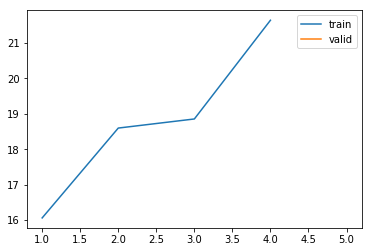

In [ ]:
#hide
learn.recorder.plot_loss(skip_start=1)

## Inference functions

In [ ]:
show_doc(Learner.validate)

<h4 id="Learner.validate" class="doc_header"><code>Learner.validate</code><a href="__main__.py#L158" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.validate</code>(**`ds_idx`**=*`1`*, **`dl`**=*`None`*, **`cbs`**=*`None`*)

Validate on `dl` with potential new `cbs`.

In [ ]:
#Test result
learn = synth_learner(n_train=5, metrics=tst_metric)
res = learn.validate()
test_eq(res[0], res[1])
x,y = learn.dls.valid_ds.tensors
test_close(res[0], F.mse_loss(learn.model(x), y), 1e-3)

In [ ]:
#hide
#Test other dl
res = learn.validate(dl=learn.dls.train)
test_eq(res[0], res[1])
x,y = learn.dls.train_ds.tensors
test_close(res[0], F.mse_loss(learn.model(x), y), 1e-3)

In [ ]:
show_doc(Learner.get_preds)

<h4 id="Learner.get_preds" class="doc_header"><code>Learner.get_preds</code><a href="__main__.py#L164" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.get_preds</code>(**`ds_idx`**=*`1`*, **`dl`**=*`None`*, **`with_input`**=*`False`*, **`with_decoded`**=*`False`*, **`with_loss`**=*`False`*, **`act`**=*`None`*, **`inner`**=*`False`*, **`reorder`**=*`True`*, **`cbs`**=*`None`*, **`save_preds`**=*`None`*, **`save_targs`**=*`None`*, **`concat_dim`**=*`0`*)

Get the predictions and targets on the `ds_idx`-th dbunchset or `dl`, optionally `with_input` and `with_loss`

`with_decoded` will also return the decoded predictions using the <code>decodes</code> function of the loss function (if it exists). For instance, fastai's `CrossEntropyFlat` takes the argmax or predictions in its decodes. 

Depending on the `loss_func` attribute of `Learner`, an activation function will be picked automatically so that the predictions make sense. For instance if the loss is a case of cross-entropy, a softmax will be applied, or if the loss is binary cross entropy with logits, a sigmoid will be applied. If you want to make sure a certain activation function is applied, you can pass it with `act`.

`save_preds` and `save_targs` should be used when your predictions are too big to fit all in memory. Give a `Path` object that points to a folder where the predictions and targets will be saved.

`concat_dim` is the batch dimension, where all the tensors will be concatenated.

`inner` is an internal attribute that tells `get_preds` it's called internally, inside another training loop, to avoid recursion errors.

> Note: If you want to use the option `with_loss=True` on a custom loss function, make sure you have implemented a `reduction` attribute that supports 'none' 

In [ ]:
#Test result
learn = synth_learner(n_train=5, metrics=tst_metric)
preds,targs = learn.get_preds()
x,y = learn.dls.valid_ds.tensors
test_eq(targs, y)
test_close(preds, learn.model(x))

preds,targs = learn.get_preds(act = torch.sigmoid)
test_eq(targs, y)
test_close(preds, torch.sigmoid(learn.model(x)))

In [ ]:
#hide
#Test get_preds work with ds not evenly divisible by bs
learn = synth_learner(n_train=2.5, metrics=tst_metric)
preds,targs = learn.get_preds(ds_idx=0)

In [ ]:
#hide
#Test other dataset
x = torch.randn(16*5)
y = 2*x + 3 + 0.1*torch.randn(16*5)
dl = DataLoader(TensorDataset(x, y), batch_size=16)
preds,targs = learn.get_preds(dl=dl)
test_eq(targs, y)
test_close(preds, learn.model(x))

#Test with loss
preds,targs,losses = learn.get_preds(dl=dl, with_loss=True)
test_eq(targs, y)
test_close(preds, learn.model(x))
test_close(losses, F.mse_loss(preds, targs, reduction='none'))

#Test with inputs
inps,preds,targs = learn.get_preds(dl=dl, with_input=True)
test_eq(inps,x)
test_eq(targs, y)
test_close(preds, learn.model(x))

In [ ]:
#hide
#Test with no target
learn = synth_learner(n_train=5)
x = torch.randn(16*5)
dl = DataLoader(TensorDataset(x), batch_size=16)
preds,targs = learn.get_preds(dl=dl)
assert targs is None

In [ ]:
#hide
#Test with targets that are tuples
def _fake_loss(x,y,z,reduction=None): return F.mse_loss(x,y)

learn = synth_learner(n_train=5)
x = torch.randn(16*5)
y = 2*x + 3 + 0.1*torch.randn(16*5)
learn.dls.n_inp=1
learn.loss_func = _fake_loss
dl = DataLoader(TensorDataset(x, y, y), batch_size=16)
preds,targs = learn.get_preds(dl=dl)
test_eq(targs, [y,y])

In [ ]:
#hide
#Test with inputs that are tuples
class _TupleModel(nn.Module):
    def __init__(self, model): 
        super().__init__()
        self.model=model
    def forward(self, x1, x2): return self.model(x1)

learn = synth_learner(n_train=5)
#learn.dls.n_inp=2
x = torch.randn(16*5)
y = 2*x + 3 + 0.1*torch.randn(16*5)
learn.model = _TupleModel(learn.model)
learn.dls = DataLoaders(DataLoader(TensorDataset(x, x, y), batch_size=16),DataLoader(TensorDataset(x, x, y), batch_size=16))
inps,preds,targs = learn.get_preds(ds_idx=0, with_input=True)
test_eq(inps, [x,x])
t = learn.get_preds(ds_idx=0, with_input=True)

In [ ]:
#hide
inps,preds,targs = learn.get_preds(ds_idx=0, with_input=True)
tst = learn.get_preds(ds_idx=0, with_input=True, with_decoded=True)

In [ ]:
show_doc(Learner.predict)

<h4 id="Learner.predict" class="doc_header"><code>Learner.predict</code><a href="__main__.py#L190" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.predict</code>(**`item`**, **`rm_type_tfms`**=*`None`*, **`with_input`**=*`False`*)

Prediction on `item`, fully decoded, loss function decoded and probabilities

It returns a tuple of three elements with, in reverse order,
- the prediction from the model, potentially passed through the activation of the loss function (if it has one)
- the decoded prediction, using the potential <code>decodes</code> method from it
- the fully decoded prediction, using the transforms used to build the `Datasets`/`DataLoaders`

`rm_type_tfms` is a deprecated argument that should not be used and will be removed in a future version. `with_input` will add the decoded inputs to the result.

> Note: To utilize `predict` you should use the entire `fastai` `DataBlock` API, as `predict` will not work with raw pytorch `DataLoaders` (and in turn, this sublibrary)

## Transfer learning

In [ ]:
#export
@patch
def freeze_to(self:Learner, n):
    "Freeze parameter groups up to `n`"
    if self.opt is None: self.create_opt()
    self.opt.freeze_to(n)
    self.opt.clear_state()

@patch
def freeze(self:Learner): 
    "Freeze up to last parameter group"
    self.freeze_to(-1)

@patch
def unfreeze(self:Learner): 
    "Unfreeze the entire model"
    self.freeze_to(0)

In [ ]:
#hide
class _TstModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
        self.tst = nn.Sequential(nn.Linear(4,5), nn.BatchNorm1d(3))
        self.tst[0].bias.data,self.tst[1].bias.data = torch.randn(5),torch.randn(3) 
    def forward(self, x): return x * self.a + self.b
    
class _PutGrad(Callback):
    def before_step(self):
        for p in self.learn.tst.parameters():
            if p.requires_grad: p.grad = torch.ones_like(p.data)

def _splitter(m): return [list(m.tst[0].parameters()), list(m.tst[1].parameters()), [m.a,m.b]]
            
learn = synth_learner(n_train=5, opt_func = partial(SGD), cbs=_PutGrad, splitter=_splitter, lr=1e-2)
learn.model = _TstModel()
learn.freeze()
init = [p.clone() for p in learn.tst.parameters()]
learn.fit(1, wd=0.)
end = list(learn.tst.parameters())
#linear was not trained
for i in [0,1]: test_close(end[i],init[i])
#bn was trained even frozen since `train_bn=True` by default
for i in [2,3]: test_close(end[i]-init[i], -0.05 * torch.ones_like(end[i]))

[0, 6.723207473754883, 5.512577533721924, '00:00']


In [ ]:
#hide
learn = synth_learner(n_train=5, opt_func = partial(SGD), cbs=_PutGrad, splitter=_splitter, train_bn=False, lr=1e-2)
learn.model = _TstModel()
learn.freeze()
init = [p.clone() for p in learn.tst.parameters()]
learn.fit(1, wd=0.)
end = list(learn.tst.parameters())
#linear and bn were not trained
for i in range(4): test_close(end[i],init[i])

learn.freeze_to(-2)
init = [p.clone() for p in learn.tst.parameters()]
learn.fit(1, wd=0.)
end = list(learn.tst.parameters())
#linear was not trained
for i in [0,1]: test_close(end[i],init[i])
#bn was trained 
for i in [2,3]: test_close(end[i]-init[i], -0.05 * torch.ones_like(end[i]))
    
learn.unfreeze()
init = [p.clone() for p in learn.tst.parameters()]
learn.fit(1, wd=0.)
end = list(learn.tst.parameters())
#linear and bn were trained
for i in range(4): test_close(end[i]-init[i], -0.05 * torch.ones_like(end[i]), 1e-3)

[0, 19.544967651367188, 14.944669723510742, '00:00']
[0, 16.02439308166504, 12.228599548339844, '00:00']
[0, 13.098505020141602, 10.00656509399414, '00:00']


## TTA

In [ ]:
#export
@patch
def tta(self:Learner, ds_idx=1, dl=None, n=4, item_tfms=None, batch_tfms=None, beta=0.25, use_max=False):
    "Return predictions on the `ds_idx` dataset or `dl` using Test Time Augmentation"
    raise NotImplementedError("You're trying to use non-basic fastai functionality. You should use the entire fastai API to get this feature")

In practice, we get the predictions `n` times with the transforms of the training set and average those. The final predictions are `(1-beta)` multiplied by this average + `beta` multiplied by the predictions obtained with the transforms of the dataset. Set `beta` to `None` to get a tuple of the predictions and tta results. You can also use the maximum of all predictions instead of an average by setting `use_max=True`.

If you want to use new transforms, you can pass them with `item_tfms` and `batch_tfms`.

> Note: To use `tta` you need to utilize the entire `fastai` `DataBlock` API, as a result it is unsupported in this sublibrary